In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as  plt
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from gensim.models import Word2Vec
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sea
from sklearn.neighbors import KNeighborsClassifier
import catboost as cat
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split


def quality_metrics(marks, preds):
    """
    Функция выводит значения основных показателей качества обучения модели
    """
    print("Accuracy: {0:.9f}".format(accuracy_score(marks, preds)))
    print("Precision: {0:.9f}".format(precision_score(marks, preds, average='micro')))
    print("Recall: {0:.9f}".format(recall_score(marks, preds, average='micro')))
    print("F1: {0:.9f}".format(f1_score(marks, preds, average='micro')))

def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features


In [3]:
dataset = pd.read_csv('selection_main.csv', delimiter=',')

In [4]:
dataset = dataset.sample(frac=1)

In [5]:
dataset

,Unnamed: 0,url,title,tags_names,abstract,class
3007,3007,https://arxiv.org/abs/2207.02601,Partial Residuated Implications Derived from P...,Logic in Computer Science,"In this paper, we reveal some relations betwee...",Fuzzy
9096,9096,https://arxiv.org/abs/2205.08435,Cyber Risk Assessment for Capital Management,Risk Management; Cryptography and Security; Op...,Cyber risk is an omnipresent risk in the incre...,Cyber Security
5273,5273,https://arxiv.org/abs/2205.15763,Exact Feature Collisions in Neural Networks,Machine Learning,Predictions made by deep neural networks were ...,Computer Vision
878,878,https://arxiv.org/abs/2201.13081,Unsupervised Anomaly Detection in 3D Brain MRI...,Image and Video Processing; Computer Vision an...,Lesion detection in brain Magnetic Resonance I...,Expert
3182,3182,https://arxiv.org/abs/2107.05392,Fuzzy-Rough Nearest Neighbour Approaches for E...,Computation and Language; Machine Learning,Social media are an essential source of meanin...,Fuzzy
...,...,...,...,...,...,...
4179,4179,https://arxiv.org/abs/2201.03435,State of the Art of User Simulation approaches...,Information Retrieval,Conversational Information Retrieval (CIR) is ...,"Information Retrieval, Recommender Systems"
8883,8883,https://arxiv.org/abs/2202.11639,Funding Covid-19 research: Insights from an ex...,Digital Libraries,To analyse the outcomes of the funding they pr...,Database
5916,5916,https://arxiv.org/abs/2201.11197,Challenges and Opportunities for Machine Learn...,Computer Vision and Pattern Recognition; Machi...,Computer Vision (CV) classifiers which disting...,Computer Vision
4012,4012,https://arxiv.org/abs/2208.04887,Early Stage Sparse Retrieval with Entity Linking,Information Retrieval,Despite the advantages of their low-resource s...,"Information Retrieval, Recommender Systems"


Датасет представляет собой набор из 10000 строк, в которых содержится информация о научных статьях из мира IT. В датасете присутвуют ссылка на статью, заголовк, тэги, краткое содержание и метка класса.

In [6]:
training, test = dataset.iloc[:7000], dataset.iloc[7000:]

In [7]:
training['class'].value_counts()

Control Systems                               723
Neural Nets                                   715
Text Mining                                   707
Database                                      702
Information Retrieval, Recommender Systems    701
Fuzzy                                         698
Cyber Security                                697
Robotic                                       697
Computer Vision                               688
Expert                                        672
Name: class, dtype: int64

In [8]:
test['class'].value_counts()

Expert                                        328
Computer Vision                               312
Cyber Security                                303
Robotic                                       303
Fuzzy                                         302
Information Retrieval, Recommender Systems    299
Database                                      298
Text Mining                                   293
Neural Nets                                   285
Control Systems                               277
Name: class, dtype: int64

In [9]:
stopwords = stopwords.words('english')

In [10]:
tokenizer = WordPunctTokenizer()
training['title'] = [tokenizer.tokenize(x.lower()) for x in training['title']]
training['abstract'] = [tokenizer.tokenize(x.lower()) for x in training['abstract']]
training['tags_names'] = [tokenizer.tokenize(x.lower()) for x in training['tags_names']]
test['title'] = [tokenizer.tokenize(x.lower()) for x in test['title']]
test['abstract'] = [tokenizer.tokenize(x.lower()) for x in test['abstract']]
test['tags_names'] = [tokenizer.tokenize(x.lower()) for x in test['tags_names']]

C:\Users\777\AppData\Local\Temp\ipykernel_21572\3745973656.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training['title'] = [tokenizer.tokenize(x.lower()) for x in training['title']]
C:\Users\777\AppData\Local\Temp\ipykernel_21572\3745973656.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training['abstract'] = [tokenizer.tokenize(x.lower()) for x in training['abstract']]
C:\Users\777\AppData\Local\Temp\ipykernel_21572\3745973656.py:4: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [11]:
for i in ['title', 'abstract', 'tags_names']:
    training[i] = [[x for x in y if x not in stopwords] for y in training[i]]
    test[i] = [[x for x in y if x not in stopwords] for y in test[i]]


C:\Users\777\AppData\Local\Temp\ipykernel_21572\779023132.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training[i] = [[x for x in y if x not in stopwords] for y in training[i]]
C:\Users\777\AppData\Local\Temp\ipykernel_21572\779023132.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i] = [[x for x in y if x not in stopwords] for y in test[i]]


In [12]:
for i in ['title', 'abstract', 'tags_names']:
    assert all(isinstance(row, (list, tuple)) for row in training[i]), "please convert each line into a list of tokens (strings)"
    assert all(all(isinstance(tok, str) for tok in row) for row in training[i]), "please convert each line into a list of tokens (strings)"
    is_latin = lambda tok: all('a' <= x.lower() <= 'z' for x in tok)
    assert all(map(lambda l: not is_latin(l) or l.islower(), map(' '.join, training[i]))), "please make sure to lowercase the data"

In [13]:
for i in ['title', 'abstract', 'tags_names']:
    assert all(isinstance(row, (list, tuple)) for row in test[i]), "please convert each line into a list of tokens (strings)"
    assert all(all(isinstance(tok, str) for tok in row) for row in test[i]), "please convert each line into a list of tokens (strings)"
    is_latin = lambda tok: all('a' <= x.lower() <= 'z' for x in tok)
    assert all(map(lambda l: not is_latin(l) or l.islower(), map(' '.join, test[i]))), "please make sure to lowercase the data"

In [14]:
training = training.drop(columns=['url', 'Unnamed: 0'])
test = test.drop(columns=['url', 'Unnamed: 0'])

In [15]:
training['text'] = training['title'] + training['tags_names'] + training['abstract']
test['text'] = test['title'] + test['tags_names'] + test['abstract']

In [16]:
training = training.drop(columns=['title', 'tags_names', 'abstract'])
test = test.drop(columns=['title', 'tags_names', 'abstract'])

In [17]:
training = training[['text', 'class']]
test = test[['text', 'class']]

In [18]:
lem = WordNetLemmatizer()
training['text'] = [[lem.lemmatize(x) for x in i] for i in training['text']]
training['text'] = [[x for x in i if x.isalpha()] for i in training['text']]

In [19]:
clses = ['Computer Vision', 'Control Systems', 'Cyber Security', 'Database', 'Expert', 'Fuzzy', "Information Retrieval, Recommender Systems", 'Neural Nets', 'Robotic', 'Text Mining']
dic_lbls = {clses[i]:i  for i in range(10)}
training = training.replace(dic_lbls)
training['labels'] = training['class']
training = training.drop(columns=['class'])
dic_lbls

{'Computer Vision': 0,
 'Control Systems': 1,
 'Cyber Security': 2,
 'Database': 3,
 'Expert': 4,
 'Fuzzy': 5,
 'Information Retrieval, Recommender Systems': 6,
 'Neural Nets': 7,
 'Robotic': 8,
 'Text Mining': 9}

In [20]:
training

,text,labels
3007,"[partial, residuated, implication, derived, pa...",5
9096,"[cyber, risk, assessment, capital, management,...",2
5273,"[exact, feature, collision, neural, network, m...",0
878,"[unsupervised, anomaly, detection, brain, mri,...",4
3182,"[fuzzy, rough, nearest, neighbour, approach, e...",5
...,...,...
313,"[mixture, expert, approach, rl, based, dialogu...",4
9403,"[resilient, machine, learning, networked, cybe...",2
1040,"[robust, deep, compressive, sensing, recurrent...",7
6619,"[extreme, zero, shot, learning, extreme, text,...",9


In [21]:
test['text'] = [[lem.lemmatize(x) for x in i] for i in test['text']]
test['text'] = [[x for x in i if x.isalpha()] for i in test['text']]
test = test.replace(dic_lbls)
test['labels'] = test['class']
test = test.drop(columns=['class'])

In [22]:
test

,text,labels
1989,"[deep, convolutional, neural, network, predict...",7
9036,"[automatic, mapping, unstructured, cyber, thre...",2
9107,"[epasad, ellipsoid, decision, boundary, based,...",2
9701,"[deploying, convolutional, network, untrusted,...",2
1380,"[tcm, sd, large, dataset, syndrome, differenti...",7
...,...,...
4179,"[state, art, user, simulation, approach, conve...",6
8883,"[funding, covid, research, insight, explorator...",3
5916,"[challenge, opportunity, machine, learning, cl...",0
4012,"[early, stage, sparse, retrieval, entity, link...",6


In [23]:
df = pd.concat([training, test])

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['labels'], test_size=0.3, stratify=df['labels'], random_state=123
)

In [25]:
corpus = X_train.values

In [61]:
w2v_model = Word2Vec(
    min_count=10,
    window=2,
    vector_size=300,
    negative=10,
    alpha=0.03,
    min_alpha=0.0007,
    sample=6e-5,
    sg=0,
    workers=15)

In [62]:
w2v_model.build_vocab(corpus)

In [63]:
w2v_model.train(corpus, total_examples=w2v_model.corpus_count, epochs=100, report_delay=1)
w2v_model.init_sims(replace=True)

C:\Users\777\AppData\Local\Temp\ipykernel_17416\2644820405.py:2: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)


In [64]:
w2v_model.wv.most_similar('convolutional')

[('neural', 0.6084334850311279),
 ('network', 0.5922396779060364),
 ('cnn', 0.5590536594390869),
 ('cnns', 0.4977514147758484),
 ('transformer', 0.49669119715690613),
 ('deep', 0.4962228536605835),
 ('convolution', 0.4611579477787018),
 ('net', 0.4608705937862396),
 ('architecture', 0.4554991126060486),
 ('gcns', 0.38372260332107544)]

In [65]:
w2v_model.wv.vectors_lockf = np.ones(len(w2v_model.wv))

In [66]:
w2v_model.wv.intersect_word2vec_format("D:\zagruzki_musor\GoogleNews-vectors-negative300.bin", binary=True)


In [67]:
w2v_model.wv.most_similar('convolutional')

[('bootstrap', 0.6762528419494629),
 ('probe', 0.672945499420166),
 ('pan', 0.6311801671981812),
 ('consortium', 0.6170359253883362),
 ('reproducible', 0.5985026359558105),
 ('civil', 0.5804609060287476),
 ('benchmark', 0.5709275007247925),
 ('solving', 0.5581292510032654),
 ('lumen', 0.558035135269165),
 ('reproducibility', 0.5520880818367004)]

In [73]:
vectorized_docs_train = vectorize(X_train.values, model = w2v_model)
vectorized_docs_test = vectorize(X_test.values, model = w2v_model)

# Дообучено на Google

In [ ]:
grid={"C":np.logspace(-3,3,20), "penalty":['l1', 'l2', 'elasticnet'], "solver":['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'], 'max_iter':[100,200,300],'verbose':[1]}
scoring = ['f1']
logreg=LogisticRegression(n_jobs=-1)
random_search = RandomizedSearchCV(estimator=logreg,
                           param_distributions=grid,
                           n_iter=100,
                           scoring=scoring,
                           refit='f1',
                           cv=3,
                           verbose=8000)

random_result = random_search.fit(vectorized_docs_train, y_train)
random_result
print(f'The best score is {random_result.best_score_:.4f}')
print('The best score standard deviation is', round(random_result.cv_results_['std_test_f1'][random_result.best_index_], 4))
print(f'The best hyperparameters are {random_result.best_params_}')

 {'verbose': 1, 'solver': 'sag', 'penalty': 'l2', 'max_iter': 100, 'C': 0.3359818286283781}

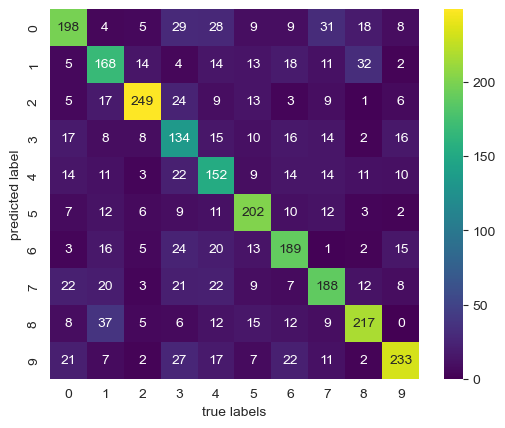

Accuracy: 0.643333333
Precision: 0.643333333
Recall: 0.643333333
F1: 0.643333333


In [75]:
clf = LogisticRegression( random_state=64, solver='lbfgs', max_iter=10000, n_jobs=-1)
clf.fit(vectorized_docs_train, y_train)

w2vec_pred_LR = clf.predict(vectorized_docs_test)

mat = confusion_matrix(y_test, w2vec_pred_LR)
sea.heatmap(mat.T, square = True, annot=True, fmt = "d", cmap='viridis')
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()
quality_metrics(y_test, w2vec_pred_LR)

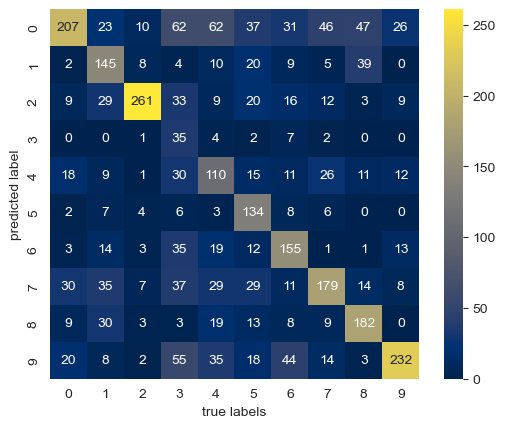

Accuracy: 0.546666667
Precision: 0.546666667
Recall: 0.546666667
F1: 0.546666667


In [79]:
clf = KNeighborsClassifier(n_neighbors=120)
clf.fit(vectorized_docs_train, y_train)

w2vec_pred_KNeighbors = clf.predict(vectorized_docs_test)

mat = confusion_matrix(y_test, w2vec_pred_KNeighbors)
sea.heatmap(mat.T, square = True, annot=True, fmt = "d", cmap='cividis')
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()
quality_metrics(y_test, w2vec_pred_KNeighbors)

In [32]:
param_grid = {"iterations":[300, 400, 500],
              #'eval_metric': ['Recall', 'Logloss', 'F1', 'TotalF1', 'Kappa', 'WKappa'],
              'grow_policy': [ 'Depthwise' , 'Lossguide'],
              'bootstrap_type': ['Poisson','Bernoulli'],
              'sampling_frequency': ['PerTree'],
              'min_data_in_leaf': [1, 2, 3],
              'subsample': [0.3, 0.5, 0.7],
              'leaf_estimation_method': ['Gradient'],
              "learning_rate": [0.0001, 0.001, 0.01, 0.1, 1],
              "depth": range(3, 21, 3),
              'random_strength': [0.7, 0.6, 0.8, 0.1],
              'boosting_type': ['Plain'],
              "reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100]}

In [33]:
ct= cat.CatBoostClassifier(task_type="GPU",loss_function='MultiClass',eval_metric='MultiClass')

random_search = ct.randomized_search(param_distributions=param_grid,
                                     X=vectorized_docs_train,
                                     y=training['labels'],
                                     cv=3,
                                     n_iter=10,
                                     verbose=1,
                                     plot=True)

print("best params:\n", ct.get_params())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.3025851	test: 2.3025848	best: 2.3025848 (0)	total: 2.94ms	remaining: 1.47s
1:	learn: 2.3025846	test: 2.3025848	best: 2.3025848 (0)	total: 4.84ms	remaining: 1.21s
2:	learn: 2.3025841	test: 2.3025846	best: 2.3025846 (2)	total: 6.57ms	remaining: 1.09s
3:	learn: 2.3025837	test: 2.3025842	best: 2.3025842 (3)	total: 8.3ms	remaining: 1.03s
4:	learn: 2.3025834	test: 2.3025841	best: 2.3025841 (4)	total: 10ms	remaining: 994ms
5:	learn: 2.3025830	test: 2.3025839	best: 2.3025839 (5)	total: 11.8ms	remaining: 971ms
6:	learn: 2.3025827	test: 2.3025839	best: 2.3025839 (5)	total: 13.6ms	remaining: 957ms
7:	learn: 2.3025820	test: 2.3025835	best: 2.3025835 (7)	total: 15.3ms	remaining: 939ms
8:	learn: 2.3025816	test: 2.3025837	best: 2.3025835 (7)	total: 17ms	remaining: 929ms
9:	learn: 2.3025809	test: 2.3025830	best: 2.3025830 (9)	total: 18.9ms	remaining: 928ms
10:	learn: 2.3025809	test: 2.3025828	best: 2.3025828 (10)	total: 21.6ms	remaining: 961ms
11:	learn: 2.3025804	test: 2.3025828	best: 2.3

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.2395167	test: 2.2514230	best: 2.2514230 (0)	total: 16.1ms	remaining: 6.43s
300:	learn: 0.2690398	test: 1.2016978	best: 1.2016978 (300)	total: 3.73s	remaining: 1.23s
399:	learn: 0.1808913	test: 1.1827222	best: 1.1827222 (399)	total: 4.82s	remaining: 0us
bestTest = 1.182722249
bestIteration = 399


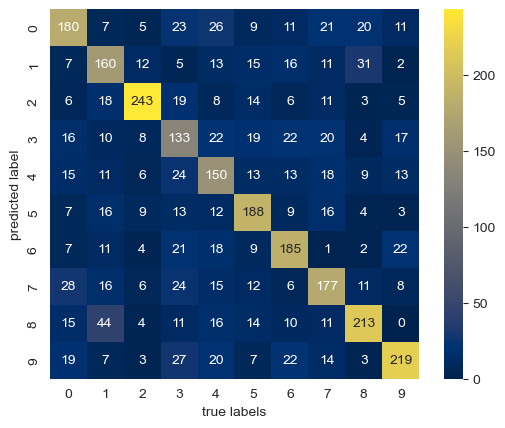

Accuracy: 0.616000000
Precision: 0.616000000
Recall: 0.616000000
F1: 0.616000000


In [80]:
params = {'loss_function': 'MultiClass',
          'eval_metric': 'TotalF1', #Recall, Logloss, F1, TotalF1, Kappa, WKappa
          'task_type': 'GPU',
          'min_data_in_leaf': 0.1,
          'depth': 12,
          'iterations': 1000,
          'subsample': 0.5,
          'random_strength': 0.6,
          'learning_rate': 0.005,
          'l2_leaf_reg': 1e-05,
          'grow_policy': 'Depthwise',
          'boosting_type': 'Plain',
          'sampling_frequency': 'PerTree',
          'auto_class_weights': 'SqrtBalanced',
          'leaf_estimation_method': 'Gradient',
          'bootstrap_type': 'Bernoulli'}

params = {'loss_function': 'MultiClass', 'eval_metric': 'MultiClass', 'task_type': 'GPU', 'min_data_in_leaf': 2, 'depth': 12, 'l2_leaf_reg': 10, 'iterations': 400, 'subsample': 0.3, 'random_strength': 0.7, 'learning_rate': 0.1, 'grow_policy': 'Lossguide', 'boosting_type': 'Plain', 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Gradient', 'bootstrap_type': 'Bernoulli'}
model_n = cat.CatBoostClassifier(**params,verbose=True)
#train model
model_n.fit(vectorized_docs_train, y_train, eval_set=(vectorized_docs_test, y_test),

                              verbose_eval=300,
                              early_stopping_rounds=500,
                              use_best_model=True,
                              plot=True)
y_cb = model_n.predict(vectorized_docs_test)
mat = confusion_matrix(y_test, y_cb)
sea.heatmap(mat.T, square = True, annot=True, fmt = "d", cmap='cividis')
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()
quality_metrics(y_test, y_cb)

# Обучено на своих Данных

In [81]:
w2v_model = Word2Vec(
    min_count=10,
    window=2,
    vector_size=300,
    negative=10,
    alpha=0.03,
    min_alpha=0.0007,
    sample=6e-5,
    sg=0,
    workers=15)
w2v_model.build_vocab(corpus)
w2v_model.train(corpus, total_examples=w2v_model.corpus_count, epochs=100, report_delay=1)
w2v_model.init_sims(replace=True)

C:\Users\777\AppData\Local\Temp\ipykernel_17416\403345055.py:13: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)


In [82]:
vectorized_docs_train = vectorize(X_train.values, model = w2v_model)
vectorized_docs_test = vectorize(X_test.values, model = w2v_model)

In [ ]:
grid={"C":np.logspace(-3,3,20), "penalty":['l1', 'l2', 'elasticnet'], "solver":['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'], 'max_iter':[100,200,300],'verbose':[1]}
scoring = ['f1']
logreg=LogisticRegression(n_jobs=-1)
random_search = RandomizedSearchCV(estimator=logreg,
                           param_distributions=grid,
                           n_iter=50,
                           scoring=scoring,
                           refit='f1',
                           cv=3,
                           verbose=8000)

random_result = random_search.fit(vectorized_docs_train, training['labels'])

In [ ]:
random_result
print(f'The best score is {random_result.best_score_:.4f}')
print('The best score standard deviation is', round(random_result.cv_results_['std_test_f1'][random_result.best_index_], 4))
print(f'The best hyperparameters are {random_result.best_params_}')

 {'verbose': 1, 'solver': 'sag', 'penalty': 'l2', 'max_iter': 100, 'C': 0.3359818286283781}
solver='lbfgs', max_iter=10000,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   10.3s finished


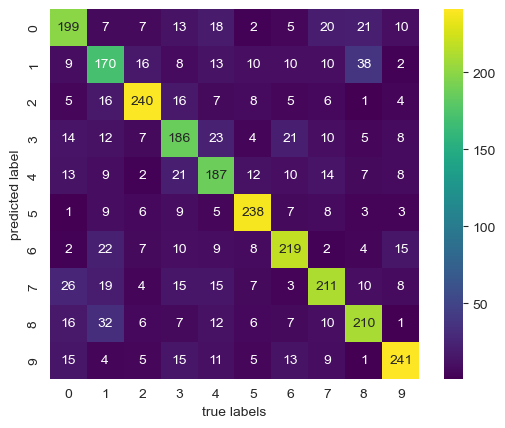

Accuracy: 0.700333333
Precision: 0.700333333
Recall: 0.700333333
F1: 0.700333333


In [83]:
clf = LogisticRegression( random_state=64, verbose=1, solver='lbfgs', penalty='l2', max_iter= 1000, C=233.9359818286283781, n_jobs=-1)
clf.fit(vectorized_docs_train, y_train)

w2vec_pred_LR = clf.predict(vectorized_docs_test)

mat = confusion_matrix(y_test, w2vec_pred_LR)
sea.heatmap(mat.T, square = True, annot=True, fmt = "d", cmap='viridis')
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()
quality_metrics(y_test, w2vec_pred_LR)

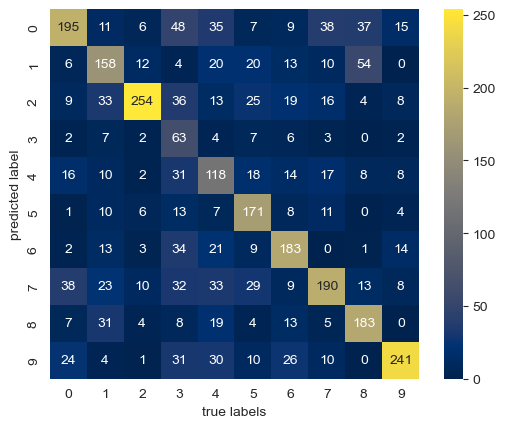

Accuracy: 0.585333333
Precision: 0.585333333
Recall: 0.585333333
F1: 0.585333333


In [84]:
clf = KNeighborsClassifier(n_neighbors=100)
clf.fit(vectorized_docs_train, y_train)

w2vec_pred_KNeighbors = clf.predict(vectorized_docs_test)

mat = confusion_matrix(y_test, w2vec_pred_KNeighbors)
sea.heatmap(mat.T, square = True, annot=True, fmt = "d", cmap='cividis')
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()
quality_metrics(y_test, w2vec_pred_KNeighbors)

In [27]:
param_grid = {"iterations": [300, 400, 500],
              #'eval_metric': ['Recall', 'Logloss', 'F1', 'TotalF1', 'Kappa', 'WKappa'],
              'grow_policy': ['Depthwise', 'Lossguide'],
              'bootstrap_type': ['Poisson', 'Bernoulli'],
              'sampling_frequency': ['PerTree'],
              'min_data_in_leaf': [1, 2, 3],
              'subsample': [0.3, 0.5, 0.7],
              'leaf_estimation_method': ['Gradient'],
              "learning_rate": [0.0001, 0.001, 0.01, 0.1, 1],
              "depth": range(3, 21, 3),
              'random_strength': [0.7, 0.6, 0.8, 0.1],
              'boosting_type': ['Plain'],
              "reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100]}
ct = cat.CatBoostClassifier(task_type="GPU", loss_function='MultiClass', eval_metric='MultiClass')

random_search = ct.randomized_search(param_distributions=param_grid,
                                     X=vectorized_docs_train,
                                     y=training['labels'],
                                     cv=3,
                                     n_iter=20,
                                     verbose=1,
                                     plot=True)

print("best params:\n", ct.get_params())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.3023591	test: 2.3028191	best: 2.3028191 (0)	total: 3.14ms	remaining: 940ms
1:	learn: 2.3023322	test: 2.3029499	best: 2.3028191 (0)	total: 5.86ms	remaining: 874ms
2:	learn: 2.3023289	test: 2.3030001	best: 2.3028191 (0)	total: 7.41ms	remaining: 734ms
3:	learn: 2.3023286	test: 2.3030106	best: 2.3028191 (0)	total: 8.97ms	remaining: 664ms
4:	learn: 2.3023286	test: 2.3030106	best: 2.3028191 (0)	total: 13.9ms	remaining: 822ms
5:	learn: 2.3023284	test: 2.3030136	best: 2.3028191 (0)	total: 15.5ms	remaining: 759ms
6:	learn: 2.3023284	test: 2.3030146	best: 2.3028191 (0)	total: 17.1ms	remaining: 716ms
7:	learn: 2.3023284	test: 2.3030151	best: 2.3028191 (0)	total: 18.7ms	remaining: 682ms
8:	learn: 2.3023284	test: 2.3030153	best: 2.3028191 (0)	total: 20.5ms	remaining: 662ms
9:	learn: 2.3023284	test: 2.3030190	best: 2.3028191 (0)	total: 22ms	remaining: 639ms
10:	learn: 2.3023284	test: 2.3030191	best: 2.3028191 (0)	total: 23.8ms	remaining: 626ms
11:	learn: 2.3023284	test: 2.3030191	best: 2

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.2558343	test: 2.2623070	best: 2.2623070 (0)	total: 16.3ms	remaining: 24.4s
300:	learn: 0.4940145	test: 1.1373853	best: 1.1373853 (300)	total: 3.65s	remaining: 14.6s
600:	learn: 0.2309082	test: 1.0967625	best: 1.0967625 (600)	total: 6.67s	remaining: 9.99s
900:	learn: 0.1312077	test: 1.0837443	best: 1.0837443 (900)	total: 9.7s	remaining: 6.45s
1200:	learn: 0.0868824	test: 1.0820093	best: 1.0814226 (1072)	total: 12.7s	remaining: 3.17s
1499:	learn: 0.0634599	test: 1.0835165	best: 1.0814226 (1072)	total: 15.7s	remaining: 0us
bestTest = 1.081422607
bestIteration = 1072
Shrink model to first 1073 iterations.


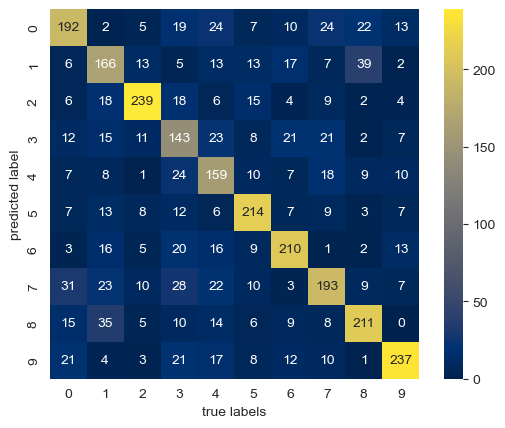

Accuracy: 0.654666667
Precision: 0.654666667
Recall: 0.654666667
F1: 0.654666667


In [85]:
params = {'loss_function': 'MultiClass',
          'eval_metric': 'TotalF1', #Recall, Logloss, F1, TotalF1, Kappa, WKappa
          'task_type': 'GPU',
          'min_data_in_leaf': 0.1,
          'depth': 12,
          'iterations': 1000,
          'subsample': 0.5,
          'random_strength': 0.6,
          'learning_rate': 0.005,
          'l2_leaf_reg': 1e-05,
          'grow_policy': 'Depthwise',
          'boosting_type': 'Plain',
          'sampling_frequency': 'PerTree',
          'auto_class_weights': 'SqrtBalanced',
          'leaf_estimation_method': 'Gradient',
          'bootstrap_type': 'Bernoulli'}

params = {'loss_function': 'MultiClass', 'eval_metric': 'MultiClass', 'task_type': 'GPU', 'min_data_in_leaf': 0.5, 'depth': 15, 'l2_leaf_reg': 10, 'iterations': 1500, 'subsample': 0.5, 'random_strength': 0.7, 'learning_rate': 0.05, 'grow_policy': 'Lossguide', 'boosting_type': 'Plain', 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Gradient', 'bootstrap_type': 'Bernoulli'}

model_n = cat.CatBoostClassifier(**params,verbose=True)
#train model
model_n.fit(vectorized_docs_train, y_train, eval_set=(vectorized_docs_test, y_test),

                              verbose_eval=300,
                              early_stopping_rounds=500,
                              use_best_model=True,
                              plot=True)
y_cb = model_n.predict(vectorized_docs_test)
mat = confusion_matrix(y_test, y_cb)
sea.heatmap(mat.T, square = True, annot=True, fmt = "d", cmap='cividis')
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()
quality_metrics(y_test, y_cb)

# FastText

In [32]:
pip install fasttext

  Using cached fasttext-0.9.2.tar.gz (68 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for fasttext
Failed to build fasttext
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [75 lines of output]
  C:\Users\777\anaconda3\lib\site-packages\setuptools\dist.py:755: SetuptoolsDeprecationWarning: Invalid dash-separated options
  !!
  
          ********************************************************************************
          Usage of dash-separated 'description-file' will not be supported in future
          versions. Please use the underscore name 'description_file' instead.
  
          By 2023-Sep-26, you need to update your project and remove deprecated calls
          or your builds will no longer be supported.
  
          See https://setuptools.pypa.io/en/latest/userguide/declarative_config.html for details.
          ********************************************************************************
  
  !!
    opt = self.warn_dash_deprecation(opt, section)
  running bdist_wheel
  running build
  running build_py
  creating build
  c

In [33]:
impo

SyntaxError: invalid syntax (2957550619.py, line 1)